# Проект [SF] Car classification

## Goal

Цель - классифицировать автомобили по фотографии.

Соревнование kaggle - https://www.kaggle.com/c/sf-dl-car-classification

## Library import

In [ ]:
import glob
import os
import shutil
import subprocess
import sys
import zipfile
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import *
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB6, Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import (Callback, EarlyStopping,
                                        LearningRateScheduler, ModelCheckpoint)
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Setup

In [ ]:
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%
CLASS_NUM = 10  # количество классов в нашей задаче
IMG_CHANNELS = 3   # у RGB 3 канала

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0


# kaggle
DATA_PATH_KAGGLE = '../input/'  # path for input data
IMG_PATH_KAGGLE = '../car/'  # path for unpacked data
# colab
DATA_PATH_COLAB = './'
IMG_PATH_COLAB = './car/'

IS_ENV_COLAB = 'google.colab' in sys.modules

if IS_ENV_COLAB:
    DATA_PATH, IMG_PATH = DATA_PATH_COLAB, IMG_PATH_COLAB
else:
    DATA_PATH, IMG_PATH = DATA_PATH_KAGGLE, IMG_PATH_KAGGLE

IMG_TRAIN_PATH = IMG_PATH + 'train'
IMG_MOCK_TRAIN_PATH = IMG_PATH + 'mock_train'

# MOCK_DATA=True - dry run for code testing
# MOCK_DATA = True
MOCK_DATA = False

## Load data

In [ ]:
def download_competition_data():
    """
    dowload data in colab from kaggle
    """
    subprocess.run(['mkdir', '-p', '/root/.kaggle'], capture_output=True)
    subprocess.run(
        ['cp',
         '/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json',
         '/root/.kaggle'],
        capture_output=True)
    subprocess.run(['kaggle', 'competitions', 'download', '-c',
                    'sf-dl-car-classification'], capture_output=True)


def unzip_data(path_input='.', path_output='.'):
    # unzip data
    if not os.path.exists(path_output):
        os.makedirs(path_output)
    if not all([dir in os.listdir(path_output) for dir in ['train',
                                                           'test_upload']]):
        for data_zip in ['train.zip', 'test.zip']:
            with zipfile.ZipFile(f'{path_input}{data_zip}', 'r') as z:
                z.extractall(path_output)


def load_train_test_from_csv(path=DATA_PATH):
    """
    load DataFrames from files (train_df, sample_submission)
    """
    train_df = pd.read_csv(f'{path}train.csv')
    sample_submission = pd.read_csv(f'{path}sample-submission.csv')
    return (train_df, sample_submission)


def decommpress_images():
    """
    load DataFrames from files (train_df, sample_submission)
    """
    if IS_ENV_COLAB:
        # running in colab
        download_competition_data()
    unzip_data(DATA_PATH, IMG_PATH)
    return load_train_test_from_csv(DATA_PATH)


def make_mock_data(n_samples=5):
    """
    Make PATH\mock_train with
    the same tree structure as PATH\train,
    copy n_samples to each directory. 
    """
    src = IMG_PATH + 'train'
    dst = IMG_PATH + 'mock_train'

    for root, dirs, files in os.walk(src):
        new_dir = root.replace(src, dst)
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        for file in files[:n_samples]:
            shutil.copy2(f'{root}/{file}', new_dir)


def copy_to_gdrive(path):
    gdrive = '/content/drive/MyDrive/Colab Notebooks/kaggle/models/'
    for file in glob.glob(path):
        shutil.copy2(file, gdrive)


def copy_from_gdrive(path):
    gdrive = '/content/drive/MyDrive/Colab Notebooks/kaggle/models/'
    from_path = gdrive + path
    for file in glob.glob(from_path):
        shutil.copy2(file, '.')


Для работы в Colab необходим подключенный GDrive и файл `content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json`

In [ ]:
decommpress_images()
# load DataFrames
train_df, sample_submission = load_train_test_from_csv()

In [ ]:
if MOCK_DATA:
    make_mock_data(n_samples=64)
    sample_submission = sample_submission[:20]
    IMG_TRAIN_PATH = IMG_MOCK_TRAIN_PATH

## EDA

In [ ]:
train_df.sample(5)

,Id,Category
99,111114.jpg,0
8450,157246.jpg,5
2882,222821.jpg,1
2177,156050.jpg,1
12856,137541.jpg,8


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное.

In [ ]:
def plot_images():
    print('Пример картинок (random sample)')
    plt.figure(figsize=(12, 8))

    random_image = train_df.sample(n=9)
    # random_image_paths = random_image['Id'].values
    # random_image_cat = random_image['Category'].values
    for index, (id, cat) in enumerate(zip(random_image['Id'],
                                          random_image['Category'])):
        # for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(f'{IMG_PATH}train/{cat}/{id}')
        plt.subplot(3, 3, index+1)
        plt.imshow(im)
        plt.title('Class: '+str(cat))
        plt.axis('off')
    plt.show()

### Примеры изображений

Пример картинок (random sample)


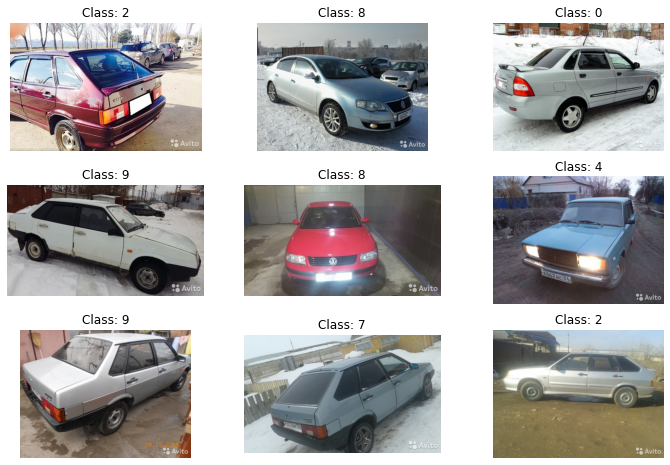

In [ ]:
plot_images()

### Разрешения изображений

In [ ]:
def plot_im_size(df):
    size = [PIL.Image.open(f'{IMG_PATH}train/{cat}/{id}').size for id,
            cat in zip(df['Id'], df['Category'])]
    s_x = list(map(lambda x: x[0], size))
    s_y = list(map(lambda x: x[1], size))
    plt.scatter(s_x, s_y, s=5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Image resolutions')
    plt.show()

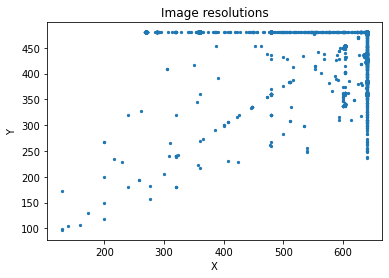

In [ ]:
plot_im_size(train_df)

## Подготовка данных

### Аугментация и создание генераторов

In [ ]:
def build_generators():
    """
    Build tuple ImageDataGenerators
    for train, validation, submission, tta submission:
    train_generator, val_generator, sub_generator, tta_generator
    """

    path_train = IMG_TRAIN_PATH
    path_test = IMG_PATH+'test_upload/'

    train_datagen = ImageDataGenerator(  # rescale=1. / 255,
        rotation_range=50,
        shear_range=0.2,
        zoom_range=[0.75, 1.25],
        brightness_range=[0.5, 1.5],
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        validation_split=VAL_SPLIT)

    test_datagen = ImageDataGenerator()  # rescale=1. / 255)

    tta_datagen = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=90,
                                     shear_range=0.2,
                                     zoom_range=[0.75, 1.25],
                                     brightness_range=[0.5, 1.5],
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)

    train_generator = train_datagen.flow_from_directory(
        # PATH+'train/',      # директория где расположены папки с картинками
        path_train,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=RANDOM_SEED,
        subset='training')  # set as training data

    val_generator = train_datagen.flow_from_directory(
        # PATH+'train/',
        path_train,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True, seed=RANDOM_SEED,
        subset='validation')  # set as validation data

    sub_generator = test_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        # directory=PATH+'test_upload/',
        directory=path_test,
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,)

    tta_generator = tta_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        # directory=PATH+'test_upload/',
        directory=path_test,
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    return (train_generator, val_generator,
            sub_generator, tta_generator)

## Построение моделей

### Xception

Используется модель `tensorflow.keras.applications.Xception` с набором весов imagenet и замененной "головой".

In [ ]:
def models_xception_base(input_shape, lr=1e-3):
    '''
    Xception new
    For Xception, call
    tf.keras.applications.xception.preprocess_input 
    on your inputs before passing them to the 
    model.xception.preprocess_input will scale input 
    pixels between -1 and 1.
    '''
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape,
                          pooling='avg')
    # unfreeze_model(base_model, ratio=unfreeze_ratio)

    inputs = keras.Input(shape=input_shape)
    x = tf.cast(inputs, tf.float32)
    x = preprocess_input(x)
    x = base_model(x)
    # base_model.summary()

    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(CLASS_NUM, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=inputs,
                  outputs=predictions,
                  name=f'Xception')
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr), metrics=["accuracy"])

    # model.summary()
    return model, base_model

### EfficientNetB6

Используется модель `tensorflow.keras.applications.EfficientNetB6` с набором весов imagenet и замененной "головой".

In [ ]:
def models_efn_base(input_shape, lr=1e-4):
    '''
    EfficientNetB6 +batchnorm
    EfficientNet models expect their inputs to be
    float tensors of pixels with values in the [0-255] range.
    '''

    base_model = EfficientNetB6(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape,
                                pooling='avg')

    # base_model.trainable = False

    x = base_model.output
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(CLASS_NUM, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input,
                  outputs=predictions,
                  name=f'EfficientNetB6')
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr),
                  metrics=["accuracy"])

    return model, base_model


## Fit, predict

Для обучения используются несколько шагов с постепенной разморозкой базовой модели и уменьшением коэффициента скорости обучения.

### Callbacks list creation

In [ ]:
def create_callbacks():
    checkpoint = ModelCheckpoint('best_model.hdf5',
                                 monitor=['val_accuracy'],
                                 verbose=1, mode='max')
    earlystop = EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    return callbacks_list

callbacks_list = create_callbacks()

### Fit, predict, submit functions

In [ ]:
def unfreeze_model(model, ratio=1):
    '''
    Unfreeze model layers.
    ratio - [0,1], 1 - all layers trainable.
    '''
    if 0 < ratio <= 1:
        model.trainable = True
        fine_tune_at = round(len(model.layers) * ratio)
        for layer in model.layers[:-fine_tune_at]:
            layer.trainable = False
    else:
        model.trainable = False


def compile_model(model, lr=1e-3):
    '''
    Compile model
    '''
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr),
                  metrics=["accuracy"])


def plot_history(history, model_name='model', score=''):
    now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

    plt.figure(figsize=(10, 5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Accuracy {model_name}. {score}')
    plt.legend()
    plt.savefig(f'accuracy_{model_name}_{now}.png', dpi=600)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Loss {model_name}')
    plt.legend()
    # plt.savefig(f'loss_{model_name}_{now}.png', dpi=600)

    plt.show()


def fine_tune_fit(model_input, input_shape, steps=[],
                  weights=None, unfreeze_ratio=0):
    """
    Build and fine-tune model over list of steps.
    Each step - (lr, unfreeze_ratio, epochs)
    """

    model, base_model = model_input(input_shape)
    if weights:
        # load weights from 'best_model.hdf5'
        # (_, ratio, _) = steps[0]
        unfreeze_model(base_model, ratio=unfreeze_ratio)
        model.load_weights(weights)

    for step, (lr, ratio, epochs) in enumerate(steps):

        step += 1  # for printing [1..N]
        unfreeze_model(base_model, ratio)
        compile_model(model, lr)
        model_name = model.name + \
            '_e' + str(epochs) + \
            '_lr_'+str(lr) + \
            '_ufratio_'+str(ratio) + \
            '_i'+str(IMG_SIZE)

        # scores = model.evaluate(val_generator, verbose=1)
        print(f"{'-'*40}\n" +
              f"{step}/{len(steps)} step training\n" +
              #   f"before {step} training\n" +
              #   f"Accuracy: {scores[1]*100:.2f}\n" +
              #   f"{'-'*40}\n" +
              f"Start training. Unfreeze: {ratio}, LR: {lr}\n" +
              f"{'-'*40}")

        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks_list
        )

        model.save(f'{model_name}_step{step}.hdf5')
        model.load_weights('best_model.hdf5')
        if IS_ENV_COLAB:
            copy_to_gdrive('*.hdf5')

        scores = model.evaluate(val_generator, verbose=1)
        print(f"{'-'*21}\n" +
              f"Accuracy step {step}: {scores[1]*100:.2f}\n" +
              f"{'-'*21}")
        plot_history(history,
                     model_name,
                     f'Accuracy step {step}: {scores[1]*100:.2f}')
        # print(f'Running time: {datetime.now() - start_time}')

    if IS_ENV_COLAB:
        copy_to_gdrive('*.hdf5')
        copy_to_gdrive('*.png')

    return model


def create_submission(predictions, name=''):
    """
    Create submission file from prediction
    """
    predictions = np.argmax(predictions, axis=-1)  # multiple categories
    label_map = (train_generator.class_indices)
    label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
    predictions = [label_map[k] for k in predictions]

    filenames_with_dir = sub_generator.filenames
    submission = pd.DataFrame(
        {'Id': filenames_with_dir,
         'Category': predictions},
        columns=['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/', '')
    submission.to_csv(f'{name}_submission.csv', index=False)


def predict_submit(model, name=''):
    """
    Create submission file from prediction,
    return predictions
    """
    predictions = model.predict(sub_generator, verbose=1)
    create_submission(predictions, name=name)
    return predictions


def predict_tta(model, tta_steps=10):
    """
    Prediction with TTA
    """
    predictions = []

    for i in range(tta_steps):
        preds = model.predict(sub_generator, verbose=1)
        predictions.append(preds)

    pred = np.mean(predictions, axis=0)
    return pred


### Xception

Обучение с использование fine-tunning и малого разрешения изображений:

In [ ]:
work_model = models_xception_base

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 224  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Steps - list of steps (learning rate, unfreeze_ratio, epochs)
#  unfreeze_ratio: 0.0 - freeze, 1.0 - unfreeze base model
steps = [(1e-3, 0, 8),
         # (1e-4, 0, 10),
         # (1e-4, 0.25, 5),
         (1e-4, 0.5, 8),
         (1e-5, 1, 5)]
if MOCK_DATA:
    steps = [(1e-3, 1, 1),
             (1e-4, 1, 1)]

In [ ]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


----------------------------------------
1/3 step training
Start training. Unfreeze: 0, LR: 0.001
----------------------------------------
Epoch 1/8
207/207 [==============================] - 249s 1s/step - loss: 1.6895 - accuracy: 0.4180 - val_loss: 1.5195 - val_accuracy: 0.4689

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
207/207 [==============================] - 244s 1s/step - loss: 1.4012 - accuracy: 0.5021 - val_loss: 1.3644 - val_accuracy: 0.5170

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
207/207 [==============================] - 244s 1s/step - loss: 1.3252 - accuracy: 0.5233 - val_loss: 1.2982 - val_accuracy: 0.5462

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
207/207 [==============================] - 244s 1s/step - loss: 1.2662 - accuracy: 0.5466 - val_loss: 1.3094 - val_accuracy: 0.5401

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
207/207 [==============================] - 243s 1s/step - loss: 1.2316 - accuracy: 0.5628 - val_loss: 1.3131 - val_accuracy: 0.5247

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
207/207 [==============================] - 246s 1s/step - loss: 1.2192 - accuracy: 0.5605 - val_loss: 1.2874 - val_accuracy: 0.5328

Epoch 00006: saving model to best_model.hdf5
Epoch 7/8
207/207 [==============================] - 246s 1s

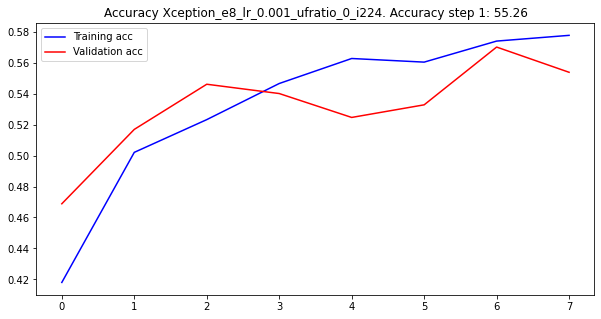

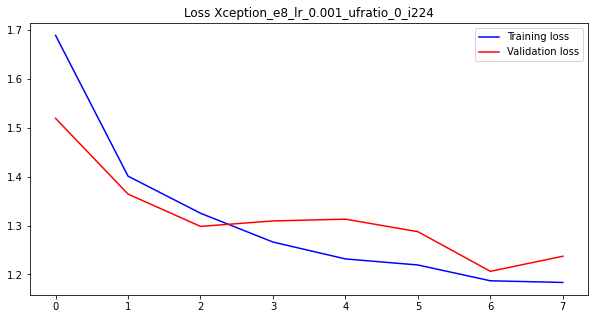

----------------------------------------
2/3 step training
Start training. Unfreeze: 0.5, LR: 0.0001
----------------------------------------
Epoch 1/8
207/207 [==============================] - 278s 1s/step - loss: 0.9521 - accuracy: 0.6591 - val_loss: 0.6879 - val_accuracy: 0.7544

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
207/207 [==============================] - 269s 1s/step - loss: 0.5352 - accuracy: 0.8078 - val_loss: 0.5249 - val_accuracy: 0.8167

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
207/207 [==============================] - 268s 1s/step - loss: 0.3934 - accuracy: 0.8627 - val_loss: 0.4595 - val_accuracy: 0.8347

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
207/207 [==============================] - 268s 1s/step - loss: 0.2974 - accuracy: 0.8951 - val_loss: 0.4233 - val_accuracy: 0.8514

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
207/207 [==============================] - 267s 1s/step - loss: 0.2409 - accuracy: 0.9091 - val_

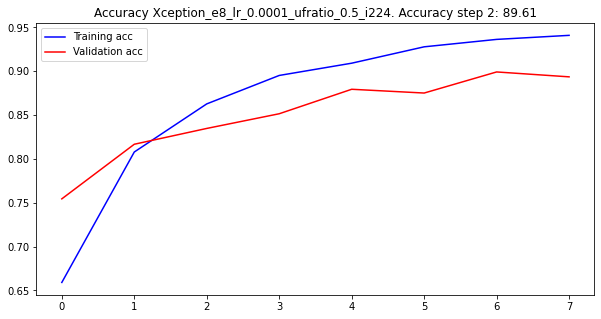

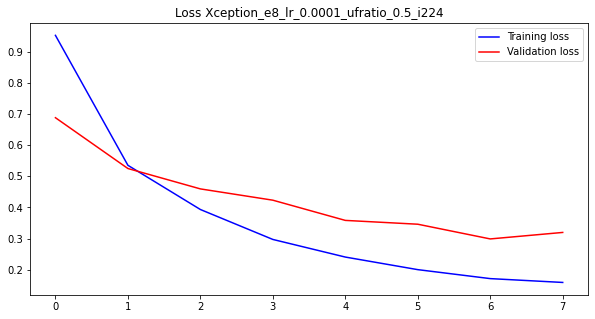

----------------------------------------
3/3 step training
Start training. Unfreeze: 1, LR: 1e-05
----------------------------------------
Epoch 1/5
207/207 [==============================] - 335s 2s/step - loss: 0.1990 - accuracy: 0.9283 - val_loss: 0.3020 - val_accuracy: 0.8935

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
207/207 [==============================] - 324s 2s/step - loss: 0.1584 - accuracy: 0.9425 - val_loss: 0.2894 - val_accuracy: 0.8974

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
207/207 [==============================] - 322s 2s/step - loss: 0.1467 - accuracy: 0.9486 - val_loss: 0.2881 - val_accuracy: 0.9073

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
207/207 [==============================] - 322s 2s/step - loss: 0.1243 - accuracy: 0.9553 - val_loss: 0.2882 - val_accuracy: 0.9021

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
207/207 [==============================] - 322s 2s/step - loss: 0.1177 - accuracy: 0.9581 - val_los

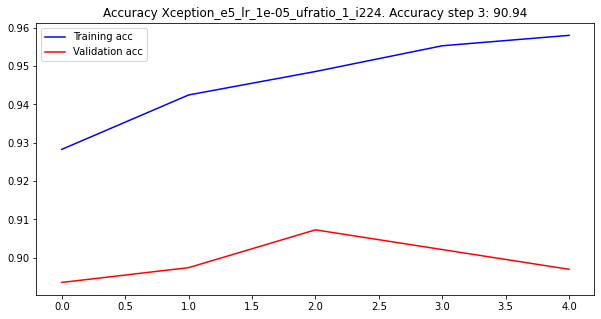

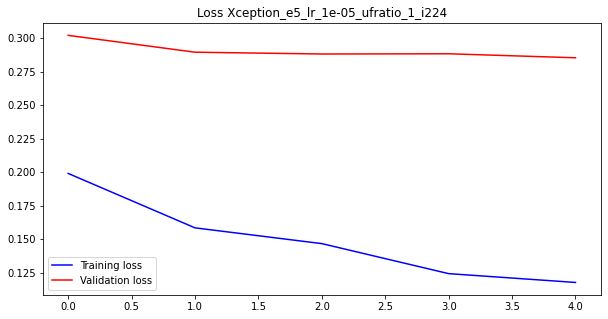

In [ ]:
model = fine_tune_fit(work_model, input_shape, steps)
(_, last_unfreeze_ratio, _) = steps[-1]


Увеличиваем разрешение изображений:


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 300  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# first step = previous step for weights loading
steps = [(1e-4, 1, 8)]

if MOCK_DATA:
  steps = [(1e-4, 1, 1)]

In [ ]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


83689472/83683744 [==============================] - 1s 0us/step
----------------------------------------
1/1 step training
Start training. Unfreeze: 1, LR: 0.0001
----------------------------------------
Epoch 1/8
414/414 [==============================] - 571s 1s/step - loss: 0.1757 - accuracy: 0.9331 - val_loss: 0.2283 - val_accuracy: 0.9214

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
414/414 [==============================] - 528s 1s/step - loss: 0.1352 - accuracy: 0.9510 - val_loss: 0.2124 - val_accuracy: 0.9261

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
414/414 [==============================] - 531s 1s/step - loss: 0.1071 - accuracy: 0.9590 - val_loss: 0.2036 - val_accuracy: 0.9339

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
414/414 [==============================] - 529s 1s/step - loss: 0.0920 - accuracy: 0.9652 - val_loss: 0.2173 - val_accuracy: 0.9317

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
414/414 [==============================] - 533s 1s/step - loss: 0.0757 - accuracy: 0.9727 - val_loss: 0.1808 - val_accuracy: 0.9425

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
414/414 [==============================] - 534s 1s/step - loss: 0.0704 - accuracy: 0.9760 - val_loss: 0.2233 - val_accuracy: 0.9352

Epoch 00006: saving model to best_model.hdf5
Epoch 7/8
414/414 [==============================] - 536s 1s

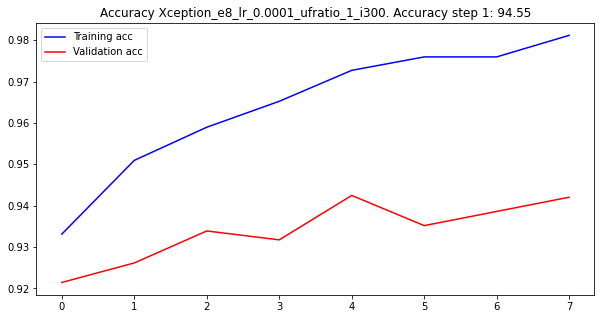

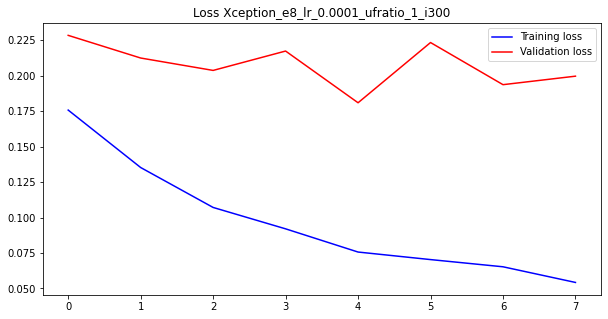

In [ ]:
# load previous weights
model = fine_tune_fit(work_model, input_shape, steps,
                      weights='best_model.hdf5',
                      unfreeze_ratio=last_unfreeze_ratio)
(_, last_unfreeze_ratio, _) = steps[-1]


Делаем предсказания с использованием полученной модели

In [ ]:
predict_xcept = predict_submit(model, name=model.name)

209/209 [==============================] - 35s 167ms/step


и использовании Test Time Augmentaition

In [ ]:
predict_xcept_tta = predict_tta(model, tta_steps=10)

209/209 [==============================] - 35s 166ms/step


In [ ]:
create_submission(predict_xcept_tta, name='xcept_tta')

### EfficientNetB6

Обучение с использование fine-tunning и малого разрешения изображений:

In [ ]:
work_model = models_efn_base

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = 224  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# list of steps (learning rate, unfreeze_ratio, epochs)
#  unfreeze_ratio: 0.0 - freeze, 1.0 - unfreeze base model
steps = [(1e-3, 0, 8),
        #  (1e-4, 0, 10),
        #  (1e-4, 0.25, 5),
         (1e-4, 0.5, 8),
         (1e-5, 1, 5)]

if MOCK_DATA:
  steps = [(1e-4, 1, 1)]

In [ ]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


165240832/165234480 [==============================] - 3s 0us/step
----------------------------------------
1/3 step training
Start training. Unfreeze: 0, LR: 0.001
----------------------------------------
Epoch 1/8
827/827 [==============================] - 296s 309ms/step - loss: 1.5005 - accuracy: 0.4770 - val_loss: 1.2122 - val_accuracy: 0.5827

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
827/827 [==============================] - 255s 309ms/step - loss: 1.2076 - accuracy: 0.5642 - val_loss: 1.0695 - val_accuracy: 0.6166

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 258s 312ms/step - loss: 1.1156 - accuracy: 0.6007 - val_loss: 1.0171 - val_accuracy: 0.6342

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 258s 312ms/step - loss: 1.0882 - accuracy: 0.6114 - val_loss: 1.0044 - val_accuracy: 0.6445

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 259s 313ms/step - loss: 1.0555 - accuracy: 0.6239 - val_loss: 1.0299 - val_accuracy: 0.6286

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==============================] - 257s 311ms/step - loss: 1.0413 - accuracy: 0.6268 - val_loss: 1.0115 - val_accuracy: 0.6432

Epoch 00006: saving model to best_model.hdf5
Epoch 7/8
827/827 [==========================

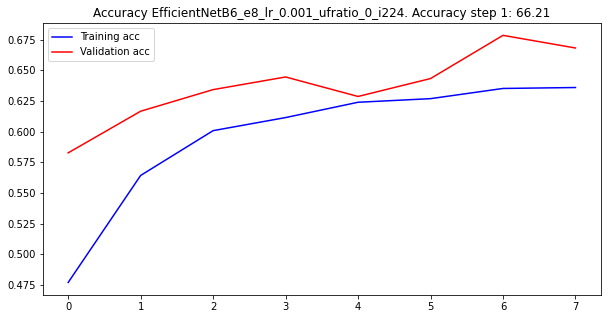

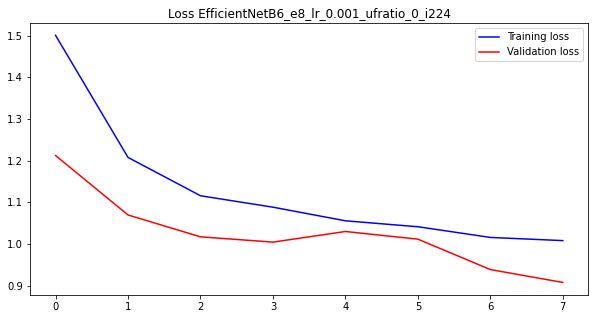

----------------------------------------
2/3 step training
Start training. Unfreeze: 0.5, LR: 0.0001
----------------------------------------
Epoch 1/8
827/827 [==============================] - 312s 355ms/step - loss: 0.9800 - accuracy: 0.6648 - val_loss: 0.4454 - val_accuracy: 0.8394

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 291s 352ms/step - loss: 0.4573 - accuracy: 0.8347 - val_loss: 0.3178 - val_accuracy: 0.8832

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 291s 352ms/step - loss: 0.3123 - accuracy: 0.8869 - val_loss: 0.2483 - val_accuracy: 0.9176

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 291s 352ms/step - loss: 0.2492 - accuracy: 0.9132 - val_loss: 0.2437 - val_accuracy: 0.9094

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 291s 352ms/step - loss: 0.2209 - accuracy

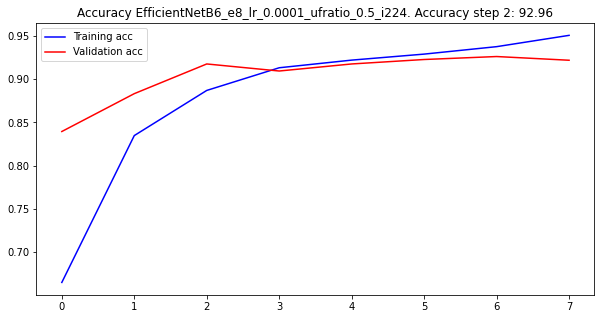

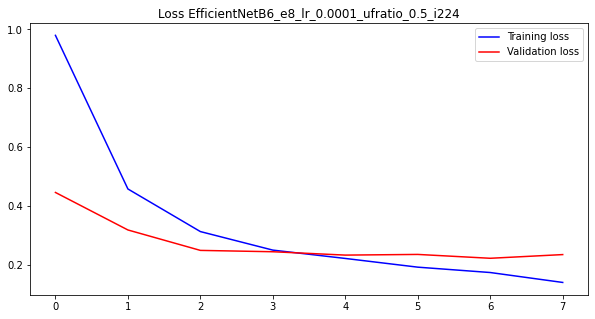

----------------------------------------
3/3 step training
Start training. Unfreeze: 1, LR: 1e-05
----------------------------------------
Epoch 1/5
827/827 [==============================] - 459s 530ms/step - loss: 0.1554 - accuracy: 0.9454 - val_loss: 0.1965 - val_accuracy: 0.9373

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
827/827 [==============================] - 435s 526ms/step - loss: 0.1174 - accuracy: 0.9572 - val_loss: 0.1874 - val_accuracy: 0.9382

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
827/827 [==============================] - 435s 525ms/step - loss: 0.1084 - accuracy: 0.9615 - val_loss: 0.1896 - val_accuracy: 0.9395

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
827/827 [==============================] - 435s 526ms/step - loss: 0.0884 - accuracy: 0.9686 - val_loss: 0.1858 - val_accuracy: 0.9450

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
827/827 [==============================] - 435s 525ms/step - loss: 0.0832 - accuracy: 0

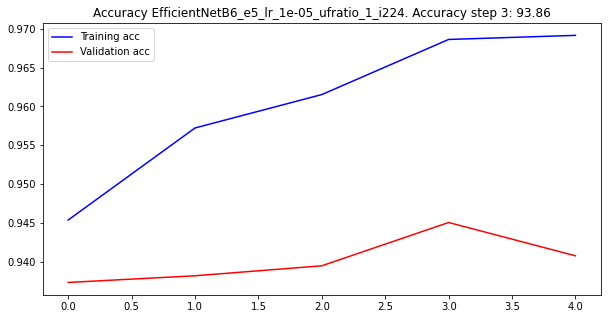

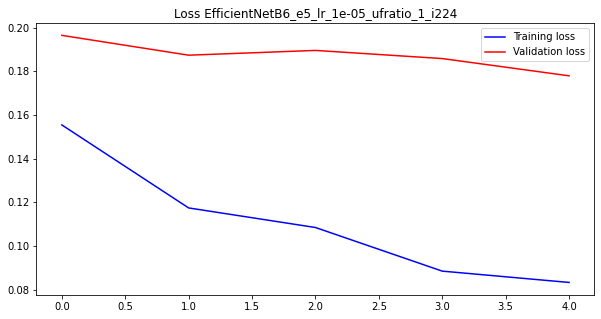

In [ ]:
model = fine_tune_fit(work_model, input_shape, steps)
( _, last_unfreeze_ratio, _) = steps[-1]


Увеличиваем разрешение изображений:


In [ ]:
BATCH_SIZE = 4
IMG_SIZE = 300  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# first step = previous step for weights loading
steps = [(1e-4, 1, 8)]

if MOCK_DATA:
  steps = [(1e-4, 1, 1)]

In [ ]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


----------------------------------------
1/1 step training
Start training. Unfreeze: 1, LR: 0.0001
----------------------------------------
Epoch 1/8
3308/3308 [==============================] - 1045s 308ms/step - loss: 0.4574 - accuracy: 0.8552 - val_loss: 0.2451 - val_accuracy: 0.9330

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
3308/3308 [==============================] - 1005s 304ms/step - loss: 0.3996 - accuracy: 0.8759 - val_loss: 0.2071 - val_accuracy: 0.9412

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
3308/3308 [==============================] - 1002s 303ms/step - loss: 0.3275 - accuracy: 0.8971 - val_loss: 0.2406 - val_accuracy: 0.9386

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
3308/3308 [==============================] - 1003s 303ms/step - loss: 0.2695 - accuracy: 0.9138 - val_loss: 0.2878 - val_accuracy: 0.9184

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
3308/3308 [==============================] - 998s 302ms/step - loss: 0.2224 - accuracy: 0.9298 - val_loss: 0.2405 - val_accuracy: 0.9360

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
3308/3308 [==============================] - 1004s 303ms/step - loss: 0.1975 - accuracy: 0.9377 - val_loss: 0.2466 - val_accuracy: 0.9231

Epoch 00006: saving model to best_model.hdf5
Epoch 7/8
3308/3308 [==========

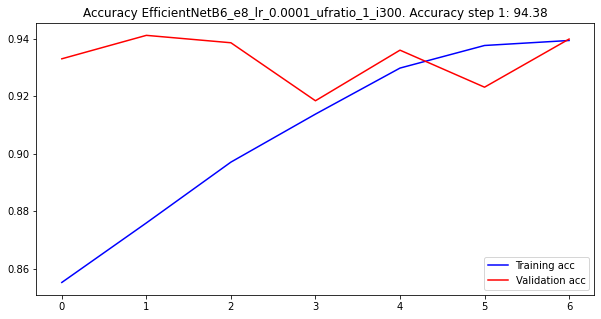

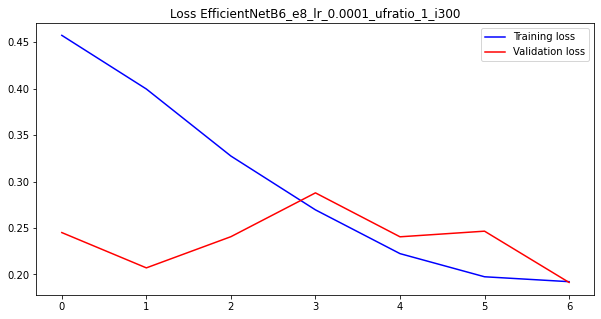

In [ ]:
# load previous weights
model = fine_tune_fit(work_model, input_shape, steps,
                      weights='best_model.hdf5',
                      unfreeze_ratio=last_unfreeze_ratio)
(_, last_unfreeze_ratio, _) = steps[-1]


Делаем предсказания с использованием полученной модели

In [ ]:
predict_efn = predict_submit(model, name=model.name)

209/209 [==============================] - 58s 277ms/step


и использовании Test Time Augmentaition

In [ ]:
predict_efn_tta = predict_tta(model, tta_steps=10)

209/209 [==============================] - 58s 276ms/step


In [ ]:
create_submission(predict_efn_tta, name='efn_tta')

### Ensemble

Используем сумму полученных предсказаний

In [ ]:
pred_sum = predict_xcept + predict_xcept_tta + predict_efn + predict_efn_tta
create_submission(pred_sum, name='ensemble')